# Penglihatan Komputer dan Analisis Citra
## Tugas 2
Jonathan Edmund Kusnadi

21/481250/PA/20950

---

## Introduction
---
Buatlah sebuah model CNN untuk melakukan klasifikasi gambar X-Ray menggunakan CNN yang mengklasifikasikan ke dalam dua kelas yaitu covid dan bukan covid. Gunakan dataset http://ugm.id/MVDataset. Buat laporan minimal 2 halaman dengan format IEEE dan sertakan link google colab pada laporan. Upload laporan dalam bentuk PDF link google drive.



## Data Preparation
---

### Read Data
---

In [1]:
import pathlib

In [4]:
data_dir = "./dataset/COVID-19-20230420T042851Z-001/COVID-19/"
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('dataset/COVID-19-20230420T042851Z-001/COVID-19')

In [5]:
list(data_dir.glob(pattern="*"))

[PosixPath('dataset/COVID-19-20230420T042851Z-001/COVID-19/Sources.txt'),
 PosixPath('dataset/COVID-19-20230420T042851Z-001/COVID-19/Negatif'),
 PosixPath('dataset/COVID-19-20230420T042851Z-001/COVID-19/Positif')]

#### Separate Categories
---

In [6]:
negative = list(data_dir.glob('Negatif/*'))
positive = list(data_dir.glob('Positif/*'))

In [7]:
print(f"images: {len(negative) + len(positive)}")
print(f"negative images: {len(negative)}\npositive images: {len(positive)}")

images: 156
negative images: 98
positive images: 58


In [8]:
print(f"negative ratio (minority class): {(58 / 156 * 100):.2f} %" )

negative ratio (minority class): 37.18 %


https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

current data is **mildly** imbalanced (minority ratio: 20%~40%)

#### Load Additional Data
---

Ukuran data sekarang sejumlah 156 data. Data kemungkinan tidak cukup untuk membangun model yang baik. Oleh karena itu, data akan ditambahkan dengan data dari dataset lain. Dataset yang digunakan adalah dataset dari https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database.

In [9]:
import splitfolders

In [23]:
data_dir = './dataset/archive/COVID-19_Radiography_Dataset/'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('dataset/archive/COVID-19_Radiography_Dataset')

In [25]:
positive = list(data_dir.glob('Positif/images/*'))
negative = list(data_dir.glob('Negatif/images/*'))

print(f"images: {len(negative) + len(positive)}")
print(f"negative images: {len(negative)}\npositive images: {len(positive)}")



images: 13964
negative images: 10290
positive images: 3674


Data terlihat imbalance maka kita akan melakukan undersampling pada data negatif. Kita melakukan undersampling dengan hanya menggunakan 50% dari data negatif.

In [34]:
splitfolders.ratio('./dataset/archive/COVID-19_Radiography_Dataset/Negatif', output='./dataset/final_dataset', seed=42, ratio=(.5, .5), group_prefix=None, move=False)

Copying files: 10290 files [00:13, 736.34 files/s] 


In [37]:
data_dir = './dataset/archive/COVID-19_Radiography_Dataset/'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('dataset/archive/COVID-19_Radiography_Dataset')

In [38]:
negative = list(data_dir.glob('Negatif/images/*'))
positive = list(data_dir.glob('Positif/images/*'))

print(f"images: {len(negative) + len(positive)}")
print(f"negative images: {len(negative)}\npositive images: {len(positive)}")

images: 8819
negative images: 5145
positive images: 3674


#### View sample images
---

In [11]:
import matplotlib.pyplot as plt

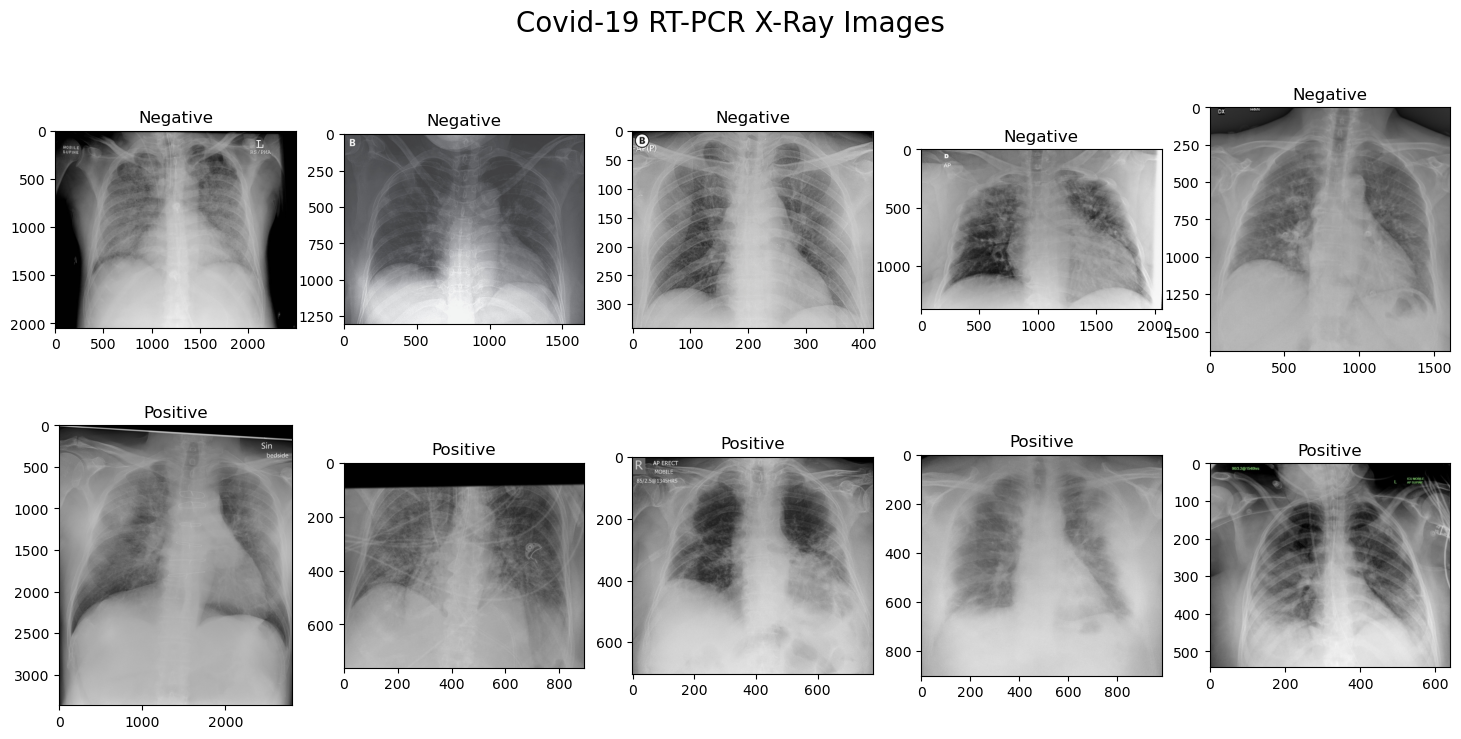

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(18, 8))
fig.suptitle("Covid-19 RT-PCR X-Ray Images", fontsize=20)

# read 5 images from the negative folder    
for i, img_path in enumerate(negative[:5]):
    ax[0, i].imshow(plt.imread(img_path))
    ax[0, i].set_title("Negative")

# read 5 images from the positive folder
for i, img_path in enumerate(positive[:5]):
    ax[1, i].imshow(plt.imread(img_path))
    ax[1, i].set_title("Positive")

plt.show()

### Split Data

Split data menjadi training, validation, dan testing set. Gunakan 60% data untuk training, 20% dari data training untuk validation, dan 20% data untuk testing.

---

In [1]:
import splitfolders
import pathlib

In [41]:
splitfolders.ratio('./dataset/archive/COVID-19_Radiography_Dataset/', output='./dataset/split', seed=42, ratio=(.6, .2, .2), group_prefix=None, move=False)

Copying files: 8819 files [00:08, 1013.44 files/s]


In [2]:
train_path = "./dataset/split/train/"
val_path = "./dataset/split/val/"
test_path = "./dataset/split/test/"

train_path = pathlib.Path(train_path)
val_path = pathlib.Path(val_path)
test_path = pathlib.Path(test_path)

### Data Preprocessing
---

In [5]:
import tensorflow as tf

In [3]:
def get_dataset_from_directory(path, image_size=(100, 100), batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=42,
        interpolation="bilinear",
    )
    
    return dataset

In [6]:
train_data = get_dataset_from_directory(path=train_path)
val_data = get_dataset_from_directory(path=val_path)
test_data = get_dataset_from_directory(path=test_path)


Found 5291 files belonging to 2 classes.
Found 1763 files belonging to 2 classes.
Found 1765 files belonging to 2 classes.


### Modelling
---

Sample training data

2023-04-26 11:54:14.498970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5291]
	 [[{{node Placeholder/_0}}]]
2023-04-26 11:54:14.499831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5291]
	 [[{{node Placeholder/_4}}]]


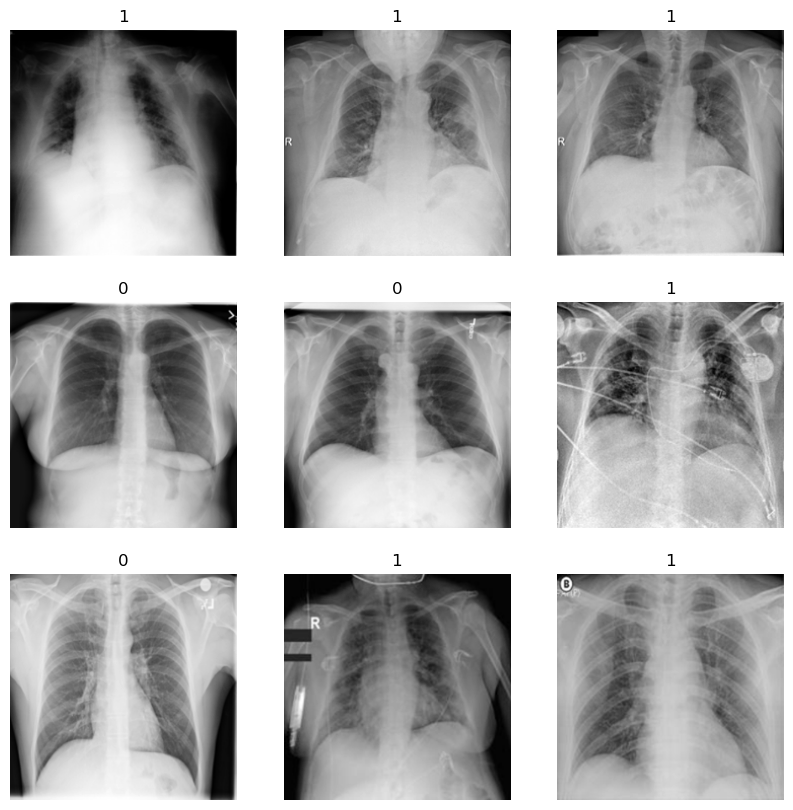

In [25]:
#display image from train data
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(int(labels[i]))
        plt.axis("off")

#### Functions
---

In [63]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### CNN Layers

In [7]:
def convolution_layer(filters=64, activation='relu', kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', batch_normalization=False, max_pooling=True):
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer))
    if batch_normalization:
        model.add(BatchNormalization())
    if max_pooling:
        model.add(MaxPooling2D(pool_size=(2, 2)))

##### Callbacks

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-2, patience=10, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=1e-1, patience=5, verbose=1, min_delta=1e-2)

##### Evaluation

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
def plot_loss(history):
    loss = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    
    plt.plot(epochs, loss, '--', label='loss_train')
    plt.plot(epochs, loss_val, '-', label='loss_val')
    plt.title('Loss Graph')
    plt.xlabel('epochs')
    plt.ylabel('value of the loss function')
    plt.ylim(0, 1)

    plt.legend()
    plt.grid()
    plt.show()

In [25]:
def plot_accuracy(history):
    acc = hist.history['accuracy']
    acc_val = hist.history['val_accuracy']
    epochs = range(1, len(acc)+1)
    
    plt.plot(epochs, acc, '--', label='accuracy_train')
    plt.plot(epochs, acc_val, '-', label='accuracy_val')

    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.ylabel('value of accuracy')
    plt.ylim(0.5, 1)
    
    plt.legend()
    plt.grid()
    plt.show()

#### Model 2
---

In [13]:
train_data = get_dataset_from_directory(path=train_path, image_size=(200, 200))
val_data = get_dataset_from_directory(path=val_path, image_size=(200, 200))
test_data = get_dataset_from_directory(path=test_path, image_size=(200, 200))

Found 5291 files belonging to 2 classes.
Found 1763 files belonging to 2 classes.
Found 1765 files belonging to 2 classes.


##### CNN Architecture

In [9]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(filters=32,activation="relu",kernel_size=5,input_shape=(200, 200, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

convolution_layer(filters=64, activation='relu', kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', batch_normalization=True, max_pooling=True)

convolution_layer(filters=128, activation='relu', kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', batch_normalization=True, max_pooling=False)

convolution_layer(filters=128, activation='relu', kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', batch_normalization=True, max_pooling=True)


model.add(Flatten(name='flatten'))

model.add(Dense(128,activation='relu',kernel_initializer='he_normal',))
model.add(Dense(128,activation='relu',kernel_initializer='he_normal',))

model.add(Dropout(0.3))

model.add(Dense(units=1,activation="sigmoid"))

In [14]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(
    train_data,
    epochs=50,
    verbose=1,
    validation_data=val_data,
    batch_size=32,
    callbacks= [early_stop,reduce_lr_on_plateau]
)

Epoch 1/50
166/166 [==============================] - 33s 130ms/step - loss: 1.5997 - accuracy: 0.7479 - val_loss: 0.5831 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 2/50
166/166 [==============================] - 19s 116ms/step - loss: 0.4523 - accuracy: 0.8155 - val_loss: 0.4079 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 3/50
166/166 [==============================] - 20s 117ms/step - loss: 0.3832 - accuracy: 0.8564 - val_loss: 0.4001 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 4/50
166/166 [==============================] - 19s 116ms/step - loss: 0.3266 - accuracy: 0.8751 - val_loss: 0.4417 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 5/50
166/166 [==============================] - 19s 112ms/step - loss: 0.2794 - accuracy: 0.9017 - val_loss: 0.7662 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 6/50
166/166 [==============================] - 19s 113ms/step - loss: 0.2702 - accuracy: 0.9012 - val_loss: 0.3310 - val_accuracy: 0.8786 - lr: 0.0010
Epoch 7/50
166/166 [==============================] 

In [27]:
model.save("./models/model2.h5")
model.save_weights("./models/model2_weights.h5")

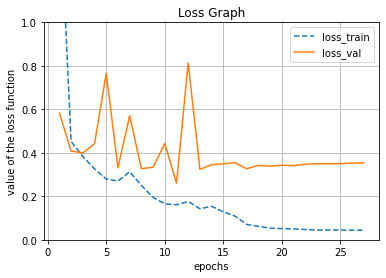

In [21]:
plot_loss(history=hist)

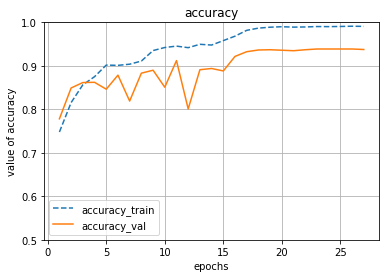

In [26]:
plot_accuracy(history=hist)

In [62]:
evaluation = model.evaluate(test_data)
print(f'loss: {evaluation[0]:.2f}, accuracy: {evaluation[1]:.2f}')

56/56 [==============================] - 3s 49ms/step - loss: 0.2299 - accuracy: 0.9388
loss: 0.23, accuracy: 0.94
